# Fractional Occupation Inversions
## Written by: Anthony Osborne
For use with the thermal inversions project 

### Import and Set up Section
Memory is likely set way too large but that is safest.

In [1]:
import psi4
import matplotlib.pyplot as plt
import numpy as np

psi4.set_options({'save_jk' : True})
psi4.set_memory(int(15.50e9))
psi4.set_num_threads(10)
psi4.core.clean()

import n2v

import matplotlib as mpl
mpl.rcParams["font.size"] = 11
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["axes.edgecolor"] = "#eae8e9" 


  Memory set to  14.435 GiB by Python driver.
  Threads set to 10 by Python driver.


### Set up molecular geometry
Isolating Fluorine from thermal inversion notebook to verify that n2v works with fractional occupations

In [2]:
F = psi4.geometry(
    """
    0 2
    F 0.0 0.0 0.0
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="F")
Ne = psi4.geometry(
    """
    0 1
    Ne 0.0 0.0 0.0
    noreorient
    nocom
    units bohr
    symmetry c1
    """, name="Ne")

### Set up PSI4 options

In [3]:
psi4.set_options({
        'basis': 'sto-6g',
        'scf_type': 'direct',
        'reference': 'uhf',
        'df_scf_guess': False,
        'e_convergence': 8,
        "opdm": True,
        'tpdm': True,
        'DFT_SPHERICAL_POINTS': 74,
        'DFT_RADIAL_POINTS': 56,
        'frac_start': 1,
        'frac_occ' : [ +3, +4, +5, -3, -4, -5 ],
        'frac_val' : [1.0, 1.0, 1.0, 6.666666666666666e-01, 6.666666666666666e-01, 6.666666666666666e-01],
        'MAXITER' : 1500,
        })

### Calculate energy and compare to value from PSI4 example file

In [4]:
F_e, F_wfn = psi4.energy("svwn/cc-pvtz", molecule=F, return_wfn=True) # type: ignore
Ne_e, Ne_wfn = psi4.energy("svwn/cc-pvtz", molecule=Ne, return_wfn=True) # type: ignore
#testEnergy, 
#print(testEnergy)
#if testEnergy == -98.91325301570028: # This number came from a Psi4 as an executable run without fractional occupations all other things held constant
#    print("No Fractional Occupations were used. Energy is:", testEnergy) 
#else: # This number came from a Psi4 as an executable run with fractional occupations all other things held constant
#    print("Fractional Occupation Occured. Energy is:", testEnergy)

### Testing Inversions

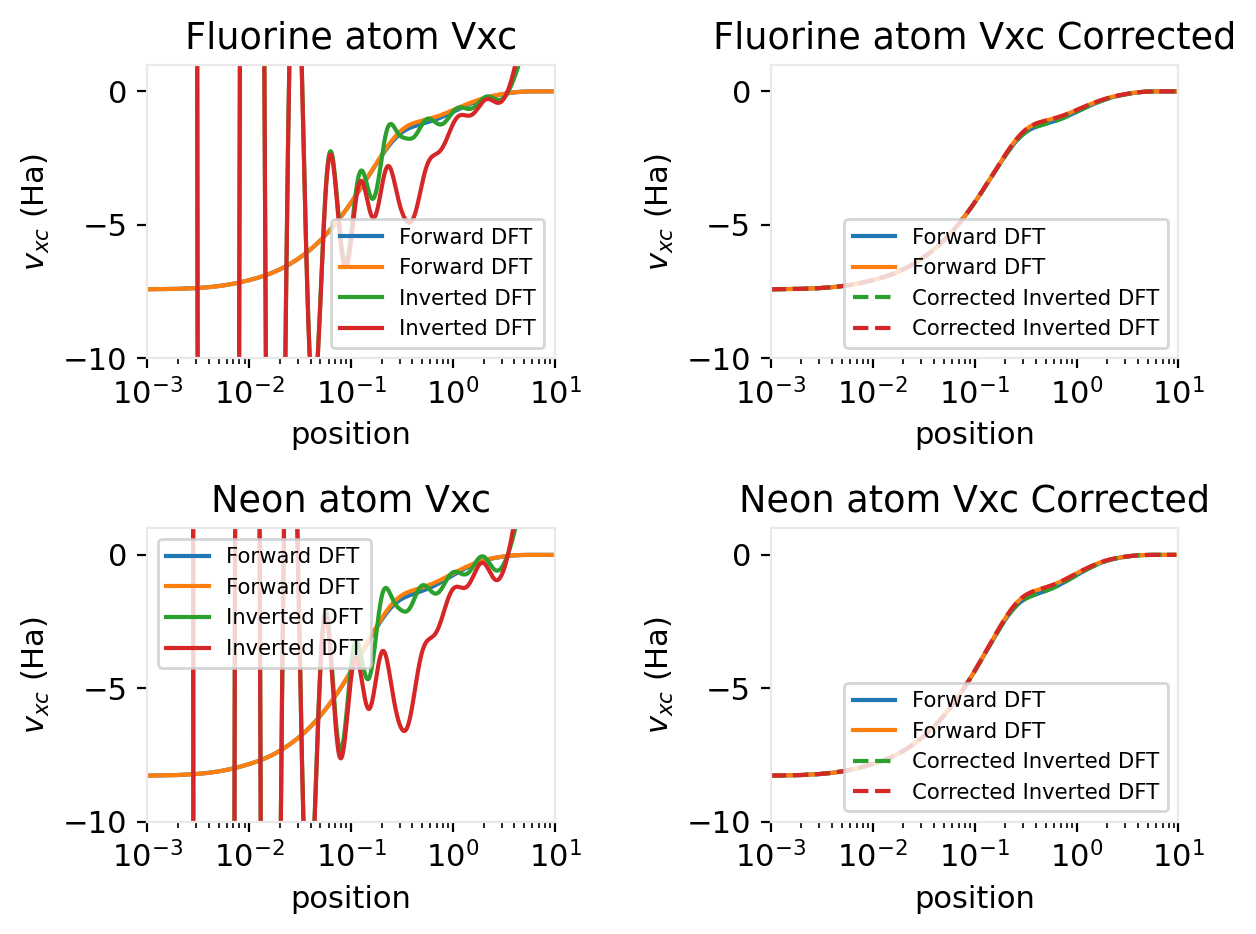

In [5]:
#N2VTEST = True
#if N2VTEST ==  True:
F_inverse = n2v.Inverter.from_wfn(F_wfn)
Ne_inverse = n2v.Inverter.from_wfn(Ne_wfn)
npoints=10002
x = np.linspace(0,10,npoints)[:,None]
y = np.zeros_like(x)
z = y
grid = np.concatenate((x,y,z), axis=1).T
F_vxc_inverted = F_inverse.invert('direct', grid=grid, correction=False)
F_vxc_inverted_corr = F_inverse.invert('direct', grid=grid, correction=True)
#Compare the performance of direct and reversed calculation of vxc. 
F_vxc0 = F_inverse.eng.grid.vxc(Da=F_wfn.Da().np, Db=F_wfn.Db().np, grid=grid) # Look here for double plotting problem
#Compare results for F with results for Ne
Ne_vxc_inverted = Ne_inverse.invert('direct', grid=grid, correction=False)
Ne_vxc_inverted_corr = Ne_inverse.invert('direct', grid=grid, correction=True)
#Compare the performance of direct and reversed calculation of vxc. 
Ne_vxc0 = Ne_inverse.eng.grid.vxc(Da=Ne_wfn.Da().np, Db=Ne_wfn.Db().np, grid=grid) # Look here for double plotting problem
#print(vxc_inverted)
#print("x array is: ", x)
#print("vxc0 array is: ",vxc0)
#---------------> Plot
fig, ax = plt.subplots(2, 2, dpi=200)
#---------------> Data
ax[0, 0].plot(x, F_vxc0, label="Forward DFT")
ax[0, 0].plot(x, F_vxc_inverted, label="Inverted DFT")
ax[1, 0].plot(x, Ne_vxc0, label="Forward DFT")
ax[1, 0].plot(x, Ne_vxc_inverted, label="Inverted DFT")
ax[0, 1].plot(x, F_vxc0, label="Forward DFT")
ax[0, 1].plot(x, F_vxc_inverted_corr, '--',label="Corrected Inverted DFT")
ax[1, 1].plot(x, Ne_vxc0, label="Forward DFT")
ax[1, 1].plot(x, Ne_vxc_inverted_corr, '--',label="Corrected Inverted DFT")
#---------------> Formatting
#-------> Labels
ax[0, 0].set_xlabel('position')
ax[0, 0].set_ylabel('$v_{xc}$ (Ha)')
ax[0, 0].legend(loc='best', fontsize='x-small')
ax[0, 1].set_xlabel('position')
ax[0, 1].set_ylabel('$v_{xc}$ (Ha)')
ax[0, 1].legend(loc='best', fontsize='x-small')
ax[1 ,1].set_xlabel('position')
ax[1, 1].set_ylabel('$v_{xc}$ (Ha)')
ax[1, 1].legend(loc='best', fontsize='x-small')
ax[1 ,0].set_xlabel('position')
ax[1, 0].set_ylabel('$v_{xc}$ (Ha)')
ax[1, 0].legend(loc='best', fontsize='x-small')
#-------> Titles
ax[0, 0].title.set_text('Fluorine atom Vxc')
ax[0, 1].title.set_text('Fluorine atom Vxc Corrected')
ax[1, 0].title.set_text('Neon atom Vxc')
ax[1, 1].title.set_text('Neon atom Vxc Corrected')
#-------> Sizing
ax[0, 0].set_xlim(0.001,10)
ax[0, 0].set_ylim(-10, 1)
ax[0, 1].set_xlim(0.001,10)
ax[0, 1].set_ylim(-10, 1)
ax[1, 1].set_xlim(0.001,10)
ax[1, 1].set_ylim(-10,1)
ax[1, 0].set_xlim(0.001,10)
ax[1, 0].set_ylim(-10,1)
#ax[0, 0].set_box_aspect(1)
#ax[0, 1].set_box_aspect(1)
#ax[1, 1].set_box_aspect(1)
ax[0, 0].set_xscale('log')
ax[0, 1].set_xscale('log')
ax[1, 1].set_xscale('log')
ax[1, 0].set_xscale('log')
fig.tight_layout()
#-------> Borders ## Have to run cell twice for this to work no idea why -- AO
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.00
#fig.suptitle("Neon atom Vxc")
    